In this notebook we attempt to predict the angular velocity and air tube motion from G4D.

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from aux import make_extended_predictor_matrix
from data import DataLoader
from plot import set_font_size

import CONFIG as C

In [2]:
from db import make_session, d_models

FILT = [d_models.Trial.walking_threshold != None]

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT).all()
session.close()

In [3]:
closed_mask = [trial.expt == 'closed_loop' for trial in trials]
driven_mask = [trial.expt == 'driven_random' for trial in trials]
mtnless_mask = [trial.expt == 'motionless' for trial in trials]

c_dict = {'closed_loop': 'k', 'driven_random': 'b', 'motionless': 'r'}

colors = [c_dict[trial.expt] for trial in trials]

In [4]:
for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, vel_filt=None)

Loading data for trial 1/52 (20170310.Fly2.2)
Loading data for trial 2/52 (20170310.Fly2.6)
Loading data for trial 3/52 (20170310.Fly3.1)
Loading data for trial 4/52 (20170313.Fly1.1)
Loading data for trial 5/52 (20170313.Fly1.2)
Loading data for trial 6/52 (20170313.Fly1.3)
Loading data for trial 7/52 (20170313.Fly1.4)
Loading data for trial 8/52 (20170313.Fly1.8)
Loading data for trial 9/52 (20170313.Fly3.1)
Loading data for trial 10/52 (20170313.Fly3.2)
Loading data for trial 11/52 (20170313.Fly3.3)
Loading data for trial 12/52 (20170330.Fly1.1)
Loading data for trial 13/52 (20170330.Fly1.2)
Loading data for trial 14/52 (20170330.Fly1.4)
Loading data for trial 15/52 (20170330.Fly1.5)
Loading data for trial 16/52 (20170331.Fly1.1)
Loading data for trial 17/52 (20170331.Fly1.2)
Loading data for trial 18/52 (20170331.Fly1.5)
Loading data for trial 19/52 (20170331.Fly1.6)
Loading data for trial 20/52 (20170331.Fly2.4)
Loading data for trial 21/52 (20170331.Fly2.6)
Loading data for trial

In [22]:
class RegressionResult(object):
    
    def __init__(self, trial_id, targ, preds, windows, valid, ys, ys_pred, coefs, rgr, details=None):
        self.trial_id = trial_id
        self.targ = targ
        self.preds = preds
        self.windows = windows
        self.valid = valid
        self.ys = ys
        self.ys_pred = ys_pred
        self.coefs = coefs
        self.rgr = rgr

        if details is None:
            details = {}
            
        self.details = details
        
        self.n_valid = valid.sum()

        if valid.sum() > 0:
            # calc R^2 val from truth and prediction
            self.err = ys_pred - ys
            self.r2 = (np.nanvar(ys) - np.nanvar(self.err)) / np.nanvar(ys)
        else:
            self.err = np.repeat(np.nan, len(ys))
            self.r2 = np.nan


def regress(trial, targ, preds, windows, valid='all'):
    """
    Predict one trial variable using other trial variables through a linear regression
    model.
    
    :param trial: trial object
    :param targ: target to predict
    :param preds: predictors
    :param windows: dict of windows to use for each predictor
        (keys are predictor names, vals are tuples of (start, end) time
            points relative to time point of prediction)
    :param valid: mask over points to include in prediction
            
    :return: RegressionResult
    """
    
    if not all([pred in windows for pred in preds]):
        raise KeyError('One window must be provided for each predictor.')
        
    xs = {pred: getattr(trial.dl, pred) for pred in preds}
    ys = getattr(trial.dl, targ)
    
    # make extended dan predictor matrix
    xs_extd = make_extended_predictor_matrix(xs, windows, order=preds)
    
    if valid == 'all':
        valid = np.repeat(True, len(ys))
    elif valid == 'none':
        valid = np.repeat(False, len(ys))
        
    # edit valid to ignore any rows with nans
    if valid.sum() > 0:
        valid_ = np.all(~np.isnan(xs_extd), 1) & (~np.isnan(ys))
        valid = valid & valid_
        
    if valid.sum() > 0:
        # at least one valid time point
        
        # fit regression
        rgr = LinearRegression(n_jobs=-1)
        rgr.fit(xs_extd[valid], ys[valid])
        
        # make target predictions
        ys_pred = np.repeat(np.nan, len(ys))
        ys_pred[valid] = rgr.predict(xs_extd[valid])
        
        # get coefficients
        window_lens = [windows[pred][1] - windows[pred][0] for pred in preds]
        splits = np.split(rgr.coef_, np.cumsum(window_lens)[:-1])
        
        coefs = {pred: s for pred, s in zip(preds, splits)}
        
    else:
        # fewer than two states
        rgr = None
        ys_pred = None
        coefs = None
        
    result = RegressionResult(
        trial_id=trial.id, targ=targ, preds=preds, windows=windows, valid=valid,
        ys=ys, ys_pred=ys_pred, coefs=coefs, rgr=rgr)
    
    return result

### Predict angular velocities using G4D

In [7]:
WINDOWS = {'G4D': (1, 6)}
rslts = {'v_ang': []}

for trial in trials:
    rslt = regress(trial=trial, targ='v_ang', preds=('G4D',), windows=WINDOWS, valid='all')
    
    # get fraction of time fly is pointed upwind rel to air tube
    frac_uw = np.mean(np.abs(trial.dl.air_tube) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts['v_ang'].append(rslt)

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


### Show R2 and G4D coefs for all trials

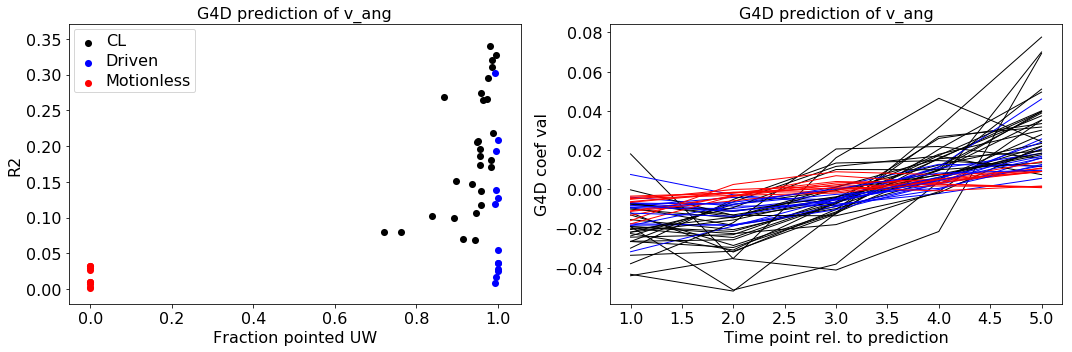

In [29]:
def plot_r2s_vs_frac_uw(targ):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

    r2s = np.array([rslt.r2 for rslt in rslts[targ]])
    fracs_uw = np.array([rslt.details['frac_uw'] for rslt in rslts[targ]])

    axs[0].scatter(fracs_uw[closed_mask], r2s[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    axs[0].scatter(fracs_uw[driven_mask], r2s[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    axs[0].scatter(fracs_uw[mtnless_mask], r2s[mtnless_mask], s=50, c=c_dict['motionless'], lw=0)

    axs[0].set_xlabel('Fraction pointed UW')
    axs[0].set_ylabel('R2')
    axs[0].set_title('G4D prediction of {}'.format(targ))
    axs[0].legend(['CL', 'Driven', 'Motionless'])

    ts_coef = np.arange(*WINDOWS['G4D'])

    for rslt, trial in zip(rslts[targ], trials):
        if rslt.coefs is not None:
            axs[1].plot(ts_coef, rslt.coefs['G4D'], color=c_dict[trial.expt], lw=1)

    axs[1].set_xlabel('Time point rel. to prediction')
    axs[1].set_ylabel('{} coef val'.format('G4D'))
    axs[1].set_title('G4D prediction of {}'.format(targ))

    for ax in axs:
        set_font_size(ax, 16)
        
plot_r2s_vs_frac_uw('v_ang')

### Predict air tube using G4D

In [32]:
rslts['ddt_air_tube'] = []

for trial in trials:
    if trial.expt == 'motionless':
        valid = 'none'
    else:
        valid = 'all'
        
    rslt = regress(trial=trial, targ='ddt_air_tube', preds=('G4D',), windows=WINDOWS, valid=valid)
    
    # get fraction of time fly is pointed upwind rel to air tube
    if not np.all(np.isnan(trial.dl.air_tube)):
        valid_mask = ~np.isnan(trial.dl.air_tube)
        frac_uw = np.mean(np.abs(trial.dl.air_tube[valid_mask]) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts['ddt_air_tube'].append(rslt)

/Users/rkp/Dropbox/Repositories/mushroom_mushroom/data.py:782: RuntimeWarning: invalid value encountered in less
  down_jumps = cc([[0.], (diff < (-jump_threshold * x_range)).astype(float)])
/Users/rkp/Dropbox/Repositories/mushroom_mushroom/data.py:783: RuntimeWarning: invalid value encountered in greater
  up_jumps = cc([[0.], (diff > (jump_threshold * x_range)).astype(float)])


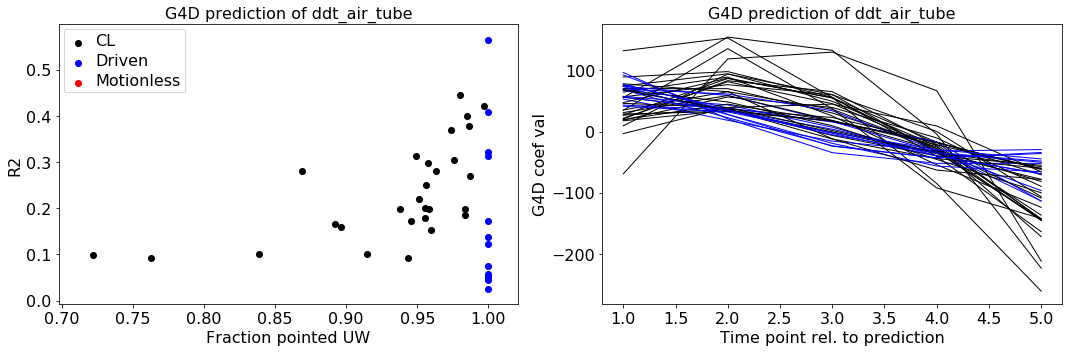

In [33]:
plot_r2s_vs_frac_uw('ddt_air_tube')

### Show results table

In [35]:
df_data = []

for tr_ctr, trial in enumerate(trials):
    df_data.append({
        'Trial': trial.name,
        'Expt': trial.expt,
        'Frac UW': rslts['v_ang'][tr_ctr].details['frac_uw'],
        'R2 (v_ang)': rslts['v_ang'][tr_ctr].r2,
        'R2 (air_tube)': rslts['ddt_air_tube'][tr_ctr].r2,
    })
    
columns = ['Trial', 'Expt', 'Frac UW', 'R2 (v_ang)', 'R2 (air_tube)']
df = pd.DataFrame(df_data, columns=columns)
df

,Trial,Expt,Frac UW,R2 (v_ang),R2 (air_tube)
0,20170310.Fly2.2,closed_loop,0.959360,0.117112,0.152528
1,20170310.Fly2.6,closed_loop,0.914390,0.070467,0.101663
2,20170310.Fly3.1,closed_loop,0.839077,0.101905,0.102049
3,20170313.Fly1.1,closed_loop,0.958138,0.137704,0.198312
4,20170313.Fly1.2,closed_loop,0.896517,0.151121,0.160452
5,20170313.Fly1.3,closed_loop,0.951105,0.207389,0.219848
6,20170313.Fly1.4,closed_loop,0.957803,0.274361,0.298029
7,20170313.Fly1.8,closed_loop,0.983590,0.180562,0.186380
8,20170313.Fly3.1,closed_loop,0.956117,0.195901,0.249711
9,20170313.Fly3.2,closed_loop,0.985040,0.320333,0.399074


### Example overlay of true and G4D-predicted air tube in trial with large R2 (20170428.Fly5.1)

(90, 150)

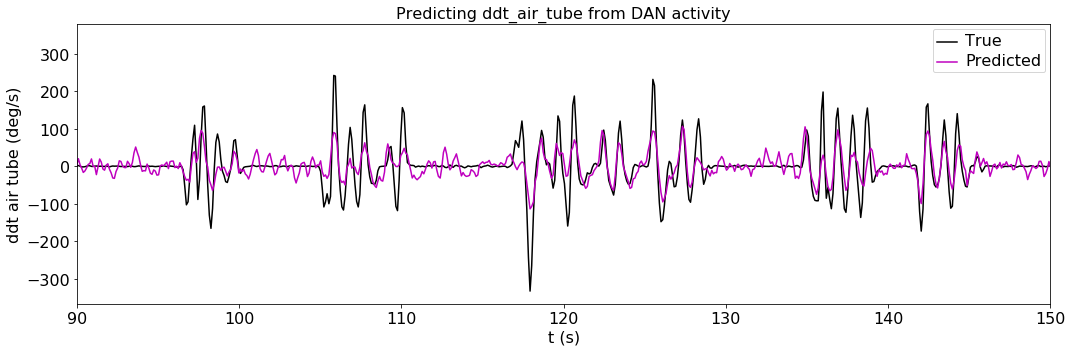

In [45]:
def plot_example_air_tube_prediction(trial_name, fig_size=(15, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
    
    trial_idx = [trial.name for trial in trials].index(trial_name)
    rslt = rslts['ddt_air_tube'][trial_idx]
    
    ts = trial.dl.timestamp_gcamp
    
    ax.plot(ts, rslt.ys, color='k')
    ax.plot(ts, rslt.ys_pred, color='m')
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('ddt air tube (deg/s)')
    ax.set_title('Predicting ddt_air_tube from DAN activity')
    ax.legend(['True', 'Predicted'])

    set_font_size(ax, 16)
    
    return ax
    
ax = plot_example_air_tube_prediction('20170428.Fly5.1')
ax.set_xlim(90, 150)